In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import joblib

In [54]:
df = pd.read_csv('/media/prince/5A4E832F4E83034D/Movie recomender/train.csv')

In [55]:
# df = df.select_dtypes(include=['float', 'int64'])/

In [56]:
df.drop('popularity', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         7999 non-null   int64  
 1   id                 7999 non-null   float64
 2   title              7999 non-null   object 
 3   original_language  7999 non-null   object 
 4   overview           7999 non-null   object 
 5   release_date       7999 non-null   object 
 6   vote_average       7999 non-null   float64
 7   vote_count         7999 non-null   float64
 8   popularity_bin     7999 non-null   float64
 9   Action             7998 non-null   float64
 10  Adventure          7998 non-null   float64
 11  Animation          7998 non-null   float64
 12  Comedy             7998 non-null   float64
 13  Crime              7998 non-null   float64
 14  Drama              7998 non-null   float64
 15  Family             7998 non-null   float64
 16  Fantasy            7998 

In [57]:
# scalling
feature_cols = ['vote_average', 'popularity_bin', 'vote_count'] + \
    [c for c in df.columns if c not in ['id','title','original_language','overview','release_date'] and df[c].dtype in ['float64','int64']]

X = df[feature_cols].copy()

print("shape:", X.shape)
print("any nulls?\n", X.isnull().sum()[X.isnull().sum() > 0])

scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

x_scaled_df = pd.DataFrame(x_scaled, columns=feature_cols)
print(x_scaled_df.describe().T)

shape: (7999, 26)
any nulls?
 Action             1
Adventure          1
Animation          1
Comedy             1
Crime              1
Drama              1
Family             1
Fantasy            1
History            1
Horror             1
Music              1
Mystery            1
Romance            1
Science Fiction    1
TV Movie           1
Thriller           1
Unknown            1
War                1
Western            1
dtype: int64
                  count          mean       std       min       25%       50%  \
vote_average     7999.0  5.147637e-16  1.000063 -2.636980 -0.679689 -0.027259   
popularity_bin   7999.0 -6.218026e-17  1.000063 -1.575887 -0.877713  0.169546   
vote_count       7999.0  1.110362e-17  1.000063 -0.511450 -0.467775 -0.364988   
Unnamed: 0       7999.0 -5.240908e-17  1.000063 -1.732063 -0.863541 -0.002639   
vote_average     7999.0  5.147637e-16  1.000063 -2.636980 -0.679689 -0.027259   
vote_count       7999.0  1.110362e-17  1.000063 -0.511450 -0.467775 -0.3

In [58]:
genre_cols = [c for c in X.columns if c not in ['vote_average','vote_count','popularity_bin']]
X[genre_cols] = X[genre_cols].fillna(0)
print("shape:", X.shape)
print("any nulls?\n", X.isnull().sum()[X.isnull().sum() > 0])

shape: (7999, 26)
any nulls?
 Series([], dtype: int64)


In [59]:
# cluster
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
df['cluster'] = kmeans.labels_
print(df['cluster'].value_counts())

score = silhouette_score(X, kmeans.labels_)
print('sillhouette_score:' , score)

cluster
3    3586
0    3258
2     766
1     286
4     103
Name: count, dtype: int64


sillhouette_score: 0.5159386371640313


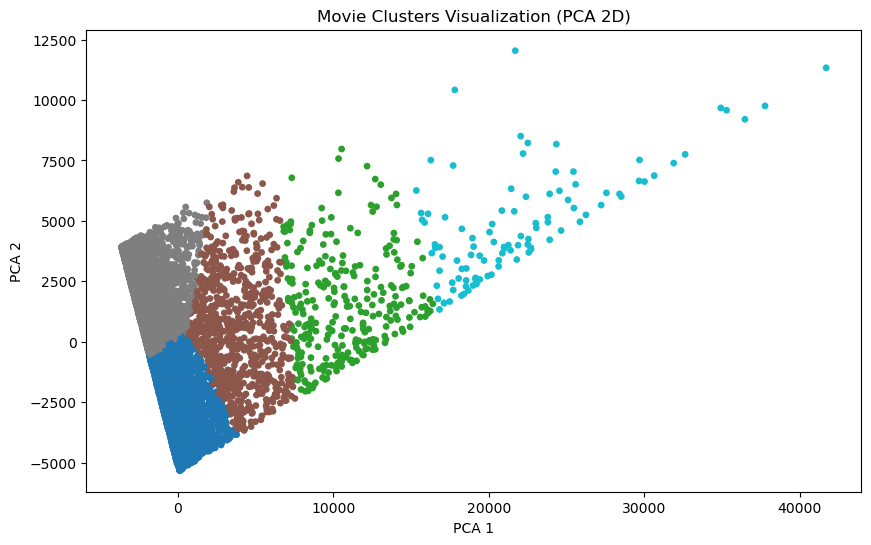

In [60]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

# Plot clusters
plt.figure(figsize=(10,6))
plt.scatter(components[:,0], components[:,1], c=kmeans.labels_, cmap='tab10', s=15)
plt.title("Movie Clusters Visualization (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [61]:
cluster_gps = df.groupby('cluster')['title'].apply(list)

In [62]:
def recommend_movies(movie_name, df, n=5):
    # 1) Find the cluster of the given movie
    cluster = df.loc[df['title'] == movie_name, 'cluster'].values[0]
    
    # 2) Get all movies in the same cluster, except the movie itself
    movies_in_cluster = df[df['cluster'] == cluster]
    movies_in_cluster = movies_in_cluster[movies_in_cluster['title'] != movie_name]
    
    # 3) Sort by vote_average + vote_count (optional weighting)
    recommended = movies_in_cluster.sort_values(by=['vote_average','vote_count'], ascending=False)
    
    # 4) Return top N movies
    return recommended['title'].head(n).tolist()


In [63]:
recommend_movies("Jurassic Park",df,n=3)

['The Shawshank Redemption', "Schindler's List", 'The Dark Knight']

In [64]:
recommend_movies("Dragon Ball Z: Lord Slug",df,n=3)

["You're Next", 'The Mountain Between Us', 'Sex and the City']

In [65]:
recommend_movies("Spider-Man 3",df,n=3)

['The Godfather: Part II', 'Life Is Beautiful', 'GoodFellas']